[2024/06/27 comments]
- report 제출 시점인 2024/06/10 에는 안되던 deeplearning 기법들이 pytorch 없이도 가동됩니다. 따라서 코드 실행 결과값이 주석(06/10 updated)과 다릅니다.
- 또한 새롭게 실행한 결과, Model 3의 성능이 저하되었습니다. 추후 문제를 파악할 예정입니다.


[2024/06/10 comments]
- autogluon 설치가 런타임 에러를 유발합니다만 런타임 재연결 후 import하면 문제없이 돌아갑니다.


- data: 건물 100개의 시간대별 전력사용량 (2022/06/01 00 ~ 2022/08/24)
- 출처: 데이콘
- train: 2022/06/01 ~ 2022/08/17
- test:  2022/08/18 ~ 2022/08/24
- 공변량 사용한 in-depth 데이터는 지식산업센터로 선정
- 전처리: 데이콘 리더보드 참고

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installation

In [2]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.0/428.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import holidays
from datetime import date
from sklearn.metrics import mean_squared_error
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

# Model 1 - Random 10 MSPE


In [2]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TS/train2.csv")
data.head(2)

,item_id,timestamp,target
0,1,20220601 00,1085.28
1,1,20220601 01,1047.36


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item_id    204000 non-null  int64  
 1   timestamp  204000 non-null  object 
 2   target     204000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ MB


In [4]:
def convert_to_datetime(timestamp_str):
    return pd.to_datetime(timestamp_str, format='%Y%m%d %H', errors='coerce')

data['timestamp'] = data['timestamp'].apply(convert_to_datetime)

data.head()

,item_id,timestamp,target
0,1,2022-06-01 00:00:00,1085.28
1,1,2022-06-01 01:00:00,1047.36
2,1,2022-06-01 02:00:00,974.88
3,1,2022-06-01 03:00:00,953.76
4,1,2022-06-01 04:00:00,986.40


In [6]:
data10 = data[data['item_id'].isin([10, 20, 30, 40, 50, 60, 71, 80, 90, 100])]

In [7]:
rdm_train = data10[data10['timestamp'] <= '2022-08-17 23:00:00']
rdm_test = data10[data10['timestamp'] >= '2022-08-18 0:00:00']

In [8]:
print(data10.shape)
print("Train 데이터")
print(rdm_train)
print("\nTest 데이터")
print(rdm_test)

(20400, 3)
Train 데이터
        item_id           timestamp   target
18360        10 2022-06-01 00:00:00  3785.76
18361        10 2022-06-01 01:00:00  3867.84
18362        10 2022-06-01 02:00:00  3972.48
18363        10 2022-06-01 03:00:00  3976.80
18364        10 2022-06-01 04:00:00  3855.36
...         ...                 ...      ...
203827      100 2022-08-17 19:00:00  1049.52
203828      100 2022-08-17 20:00:00   874.32
203829      100 2022-08-17 21:00:00   678.24
203830      100 2022-08-17 22:00:00   632.64
203831      100 2022-08-17 23:00:00   552.72

[18720 rows x 3 columns]

Test 데이터
        item_id           timestamp   target
20232        10 2022-08-18 00:00:00  4493.28
20233        10 2022-08-18 01:00:00  4450.08
20234        10 2022-08-18 02:00:00  4341.60
20235        10 2022-08-18 03:00:00  4204.32
20236        10 2022-08-18 04:00:00  4143.36
...         ...                 ...      ...
203995      100 2022-08-24 19:00:00   881.04
203996      100 2022-08-24 20:00:00   798.9

In [9]:
train = TimeSeriesDataFrame(rdm_train)

In [10]:
predictor = TimeSeriesPredictor(
    prediction_length = 168,
    path = "autogluon-energy-10-3600",
    target = "target",
    eval_metric = "MSE"
)

predictor.fit(
    train,
    presets = "high_quality",
    time_limit = 3600
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'autogluon-energy-10-3600'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Fri May 24 14:06:39 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.93 GB / 12.67 GB (86.2%)
Disk Space Avail:   76.22 GB / 107.72 GB (70.8%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 168,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 3600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 18720 rows, 

In [11]:
predictions = predictor.predict(train)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2  \
item_id timestamp                                                    
10      2022-08-18 00:00:00  4305.514020  4009.140615  4098.326284   
        2022-08-18 01:00:00  4292.862543  3874.357393  4030.287662   
        2022-08-18 02:00:00  4232.554616  3805.585524  3955.227677   
        2022-08-18 03:00:00  4204.772141  3785.038183  3931.588376   
        2022-08-18 04:00:00  4144.663288  3688.021929  3872.456655   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
10      2022-08-18 00:00:00  4168.255473  4239.536046  4299.157635   
        2022-08-18 01:00:00  4135.236783  4216.401816  4271.775802   
        2022-08-18 02:00:00  4084.566400  4165.995392  4238.868277   
        2022-08-18 03:00:00  4015.294625  4111.479447  4192.758430   
        2022-08-18 04:00:00  3963.976211  4055.200772  4133.326447   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
10      2022-08-18 00:00:00  4382.146357  4468.342488  4548.307624   
        2022-08-18 01:00:00  4397.182978  4487.406251  4576.865393   
        2022-08-18 02:00:00  4326.420292  4445.940092  4536.513917   
        2022-08-18 03:00:00  4300.220010  4390.758797  4505.413537   
        2022-08-18 04:00:00  4218.709269  4343.512569  4463.472999   

                                     0.9  
item_id timestamp                         
10      2022-08-18 00:00:00  4636.974312  
        2022-08-18 01:00:00  4689.129294  
        2022-08-18 02:00:00  4660.948471  
        2022-08-18 03:00:00  4646.392130  
        2022-08-18 04:00:00  4630.380846

In [12]:
predictions.tail()

mean         0.1         0.2         0.3  \
item_id timestamp                                                              
100     2022-08-24 19:00:00  1072.995373  498.641132  696.060858  843.834673   
        2022-08-24 20:00:00   979.238003  407.022698  612.660804  764.305805   
        2022-08-24 21:00:00   806.213476  244.717250  441.967554  586.034225   
        2022-08-24 22:00:00   691.413771  152.855358  342.979970  484.260205   
        2022-08-24 23:00:00   595.775233   78.303411  264.082714  398.296202   

                                    0.4          0.5          0.6  \
item_id timestamp                                                   
100     2022-08-24 19:00:00  957.999553  1079.444128  1180.200708   
        2022-08-24 20:00:00  882.748435   986.898425  1085.798115   
        2022-08-24 21:00:00  703.412585   812.931308   914.690694   
        2022-08-24 22:00:00  599.445970   693.032722   794.621843   
        2022-08-24 23:00:00  506.071349   595.405470   688.606183   

                                     0.7          0.8          0.9  
item_id timestamp                                                   
100     2022-08-24 19:00:00  1289.018238  1432.937479  1624.599859  
        2022-08-24 20:00:00  1195.511011  1325.547095  1524.126475  
        2022-08-24 21:00:00  1024.337953  1163.493497  1352.038822  
        2022-08-24 22:00:00   905.978146  1038.030076  1222.860787  
        2022-08-24 23:00:00   804.485911   928.959774  1119.339494

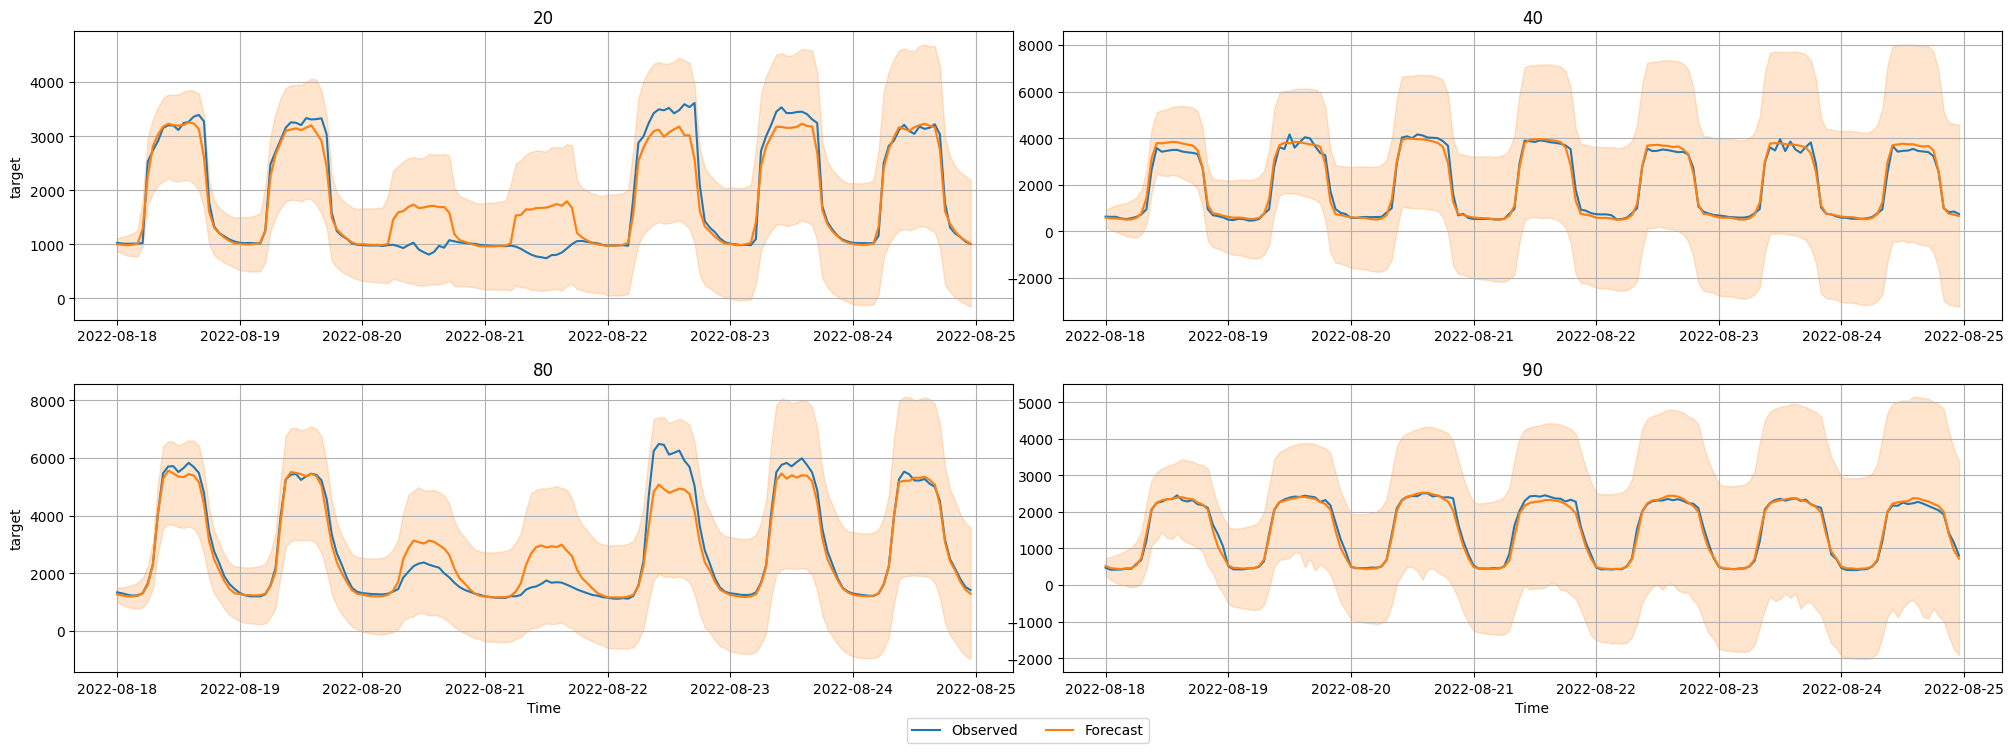

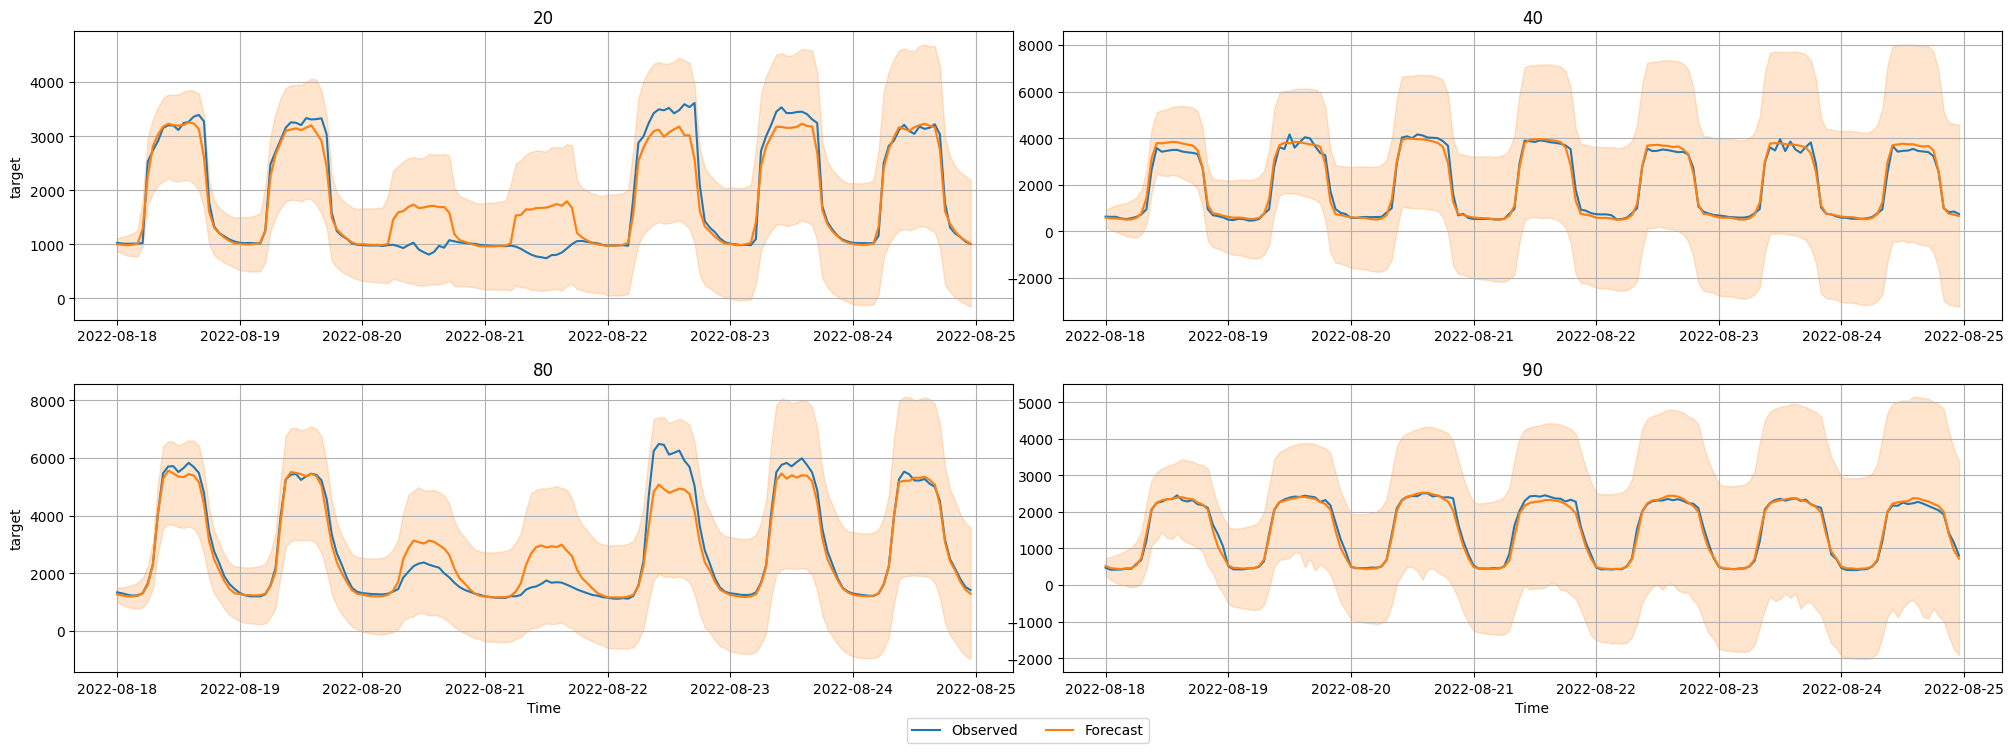

In [13]:
test = TimeSeriesDataFrame(rdm_test)

predictor.plot(test, predictions, quantile_levels=[0.1, 0.9], item_ids = [20, 40, 80, 90], max_num_item_ids = 4)

In [14]:
predictor.model_best

'WeightedEnsemble'

In [15]:
actuals = rdm_test[['item_id', 'timestamp', 'target']]
predicted = predictions.reset_index()[['item_id', 'timestamp', 'mean']]
merged_df = pd.merge(rdm_test, predicted, on=['item_id', 'timestamp'])

merged_df['squared_error'] = (merged_df['target'] - merged_df['mean']) ** 2
mspe_value = np.mean(merged_df['squared_error'])

print(f"MSPE: {mspe_value}")

merged_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_rdm10.csv', index=False)

MSPE: 77442.92671135039


Random 10 bldg MSPE comparison
> Auto.Arima (R) 정상작동. 298795.62

> AG-TS 정상작동 (AutoARIMA 포함 DeepAR 미포함) 86753.62

> 우수한 성능 입증


# 지식산업센터

In [16]:
datak = pd.read_csv('/content/drive/MyDrive/TimeSeries/knowledge.csv')
datak = datak.drop(['Unnamed: 0'], axis=1)
datak['date_time'] = pd.to_datetime(datak['date_time'])

building_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TS/building_info2.csv')
building_info = building_info.drop(['Unnamed: 0','building_type'], axis=1)

In [17]:
datak.isnull().sum()

building_number             0
date_time                   0
temperature                 0
rainfall                12918
windspeed                   0
humidity                    0
sunshine                 6159
solar_radiation          6159
power_consumption           0
building_type               0
total_area                  0
cooling_area                0
solar_power_capacity        0
ess_capacity                0
pcs_capacity                0
dtype: int64

In [18]:
print(len(datak[datak['solar_power_capacity'] == '-']))
print(len(datak[datak['ess_capacity'] == '-']))
print(len(datak[datak['pcs_capacity'] == '-']))

16320
16320
16320


In [19]:
datak = datak.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)

In [20]:
datak.shape

(16320, 12)

# Model 2 - Knowledge data with no covariates

In [22]:
df_nc = datak[['building_number', 'date_time', 'power_consumption']]

nc_train = df_nc[df_nc['date_time'] <= '2022-08-17 23:00:00']
nc_test = df_nc[df_nc['date_time'] >= '2022-08-18 00:00:00']

In [23]:
print(df_nc.shape)
print(nc_train.shape)
print(nc_test.shape)

(16320, 3)
(14976, 3)
(1344, 3)


In [24]:
train_nc = TimeSeriesDataFrame.from_data_frame(
    nc_train,
    id_column = "building_number",
    timestamp_column = "date_time",
)
train_nc.head()

power_consumption
item_id timestamp                             
77      2022-06-01 00:00:00             954.00
        2022-06-01 01:00:00             934.56
        2022-06-01 02:00:00             873.72
        2022-06-01 03:00:00             865.80
        2022-06-01 04:00:00             887.40

In [25]:
predictor = TimeSeriesPredictor(
    prediction_length = 168,
    path = "autogluon-energy-knowledge-high-nc-3600",
    target = "power_consumption",
    eval_metric = "MSE",
)

predictor.fit(
    train_nc,
    presets = "high_quality",
    time_limit = 3600
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'autogluon-energy-knowledge-high-nc-3600'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Fri May 24 14:06:39 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.70 GB / 12.67 GB (76.5%)
Disk Space Avail:   76.19 GB / 107.72 GB (70.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 168,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'power_consumption',
 'time_limit': 3600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided tr

In [26]:
predictions = predictor.predict(train_nc)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1159.742624  1014.552762  1059.140673   
        2022-08-18 01:00:00  1107.234041   914.964254   975.524064   
        2022-08-18 02:00:00  1065.002026   836.673361   909.265208   
        2022-08-18 03:00:00  1052.505765   795.835368   876.496957   
        2022-08-18 04:00:00  1068.870690   785.367709   875.639197   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1093.457502  1124.358604  1160.071768   
        2022-08-18 01:00:00  1021.452357  1061.540381  1106.700699   
        2022-08-18 02:00:00   963.504452  1011.623967  1063.933737   
        2022-08-18 03:00:00   938.988321   991.938093  1049.550215   
        2022-08-18 04:00:00   944.636506  1003.666046  1066.932941   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1196.781548  1226.849437  1262.442639   
        2022-08-18 01:00:00  1151.761564  1191.953229  1239.325361   
        2022-08-18 02:00:00  1116.701068  1163.997466  1219.665167   
        2022-08-18 03:00:00  1108.447649  1162.971566  1225.008193   
        2022-08-18 04:00:00  1130.861969  1190.926710  1259.261330   

                                     0.9  
item_id timestamp                         
77      2022-08-18 00:00:00  1308.838904  
        2022-08-18 01:00:00  1301.221612  
        2022-08-18 02:00:00  1292.950422  
        2022-08-18 03:00:00  1307.785095  
        2022-08-18 04:00:00  1353.313043

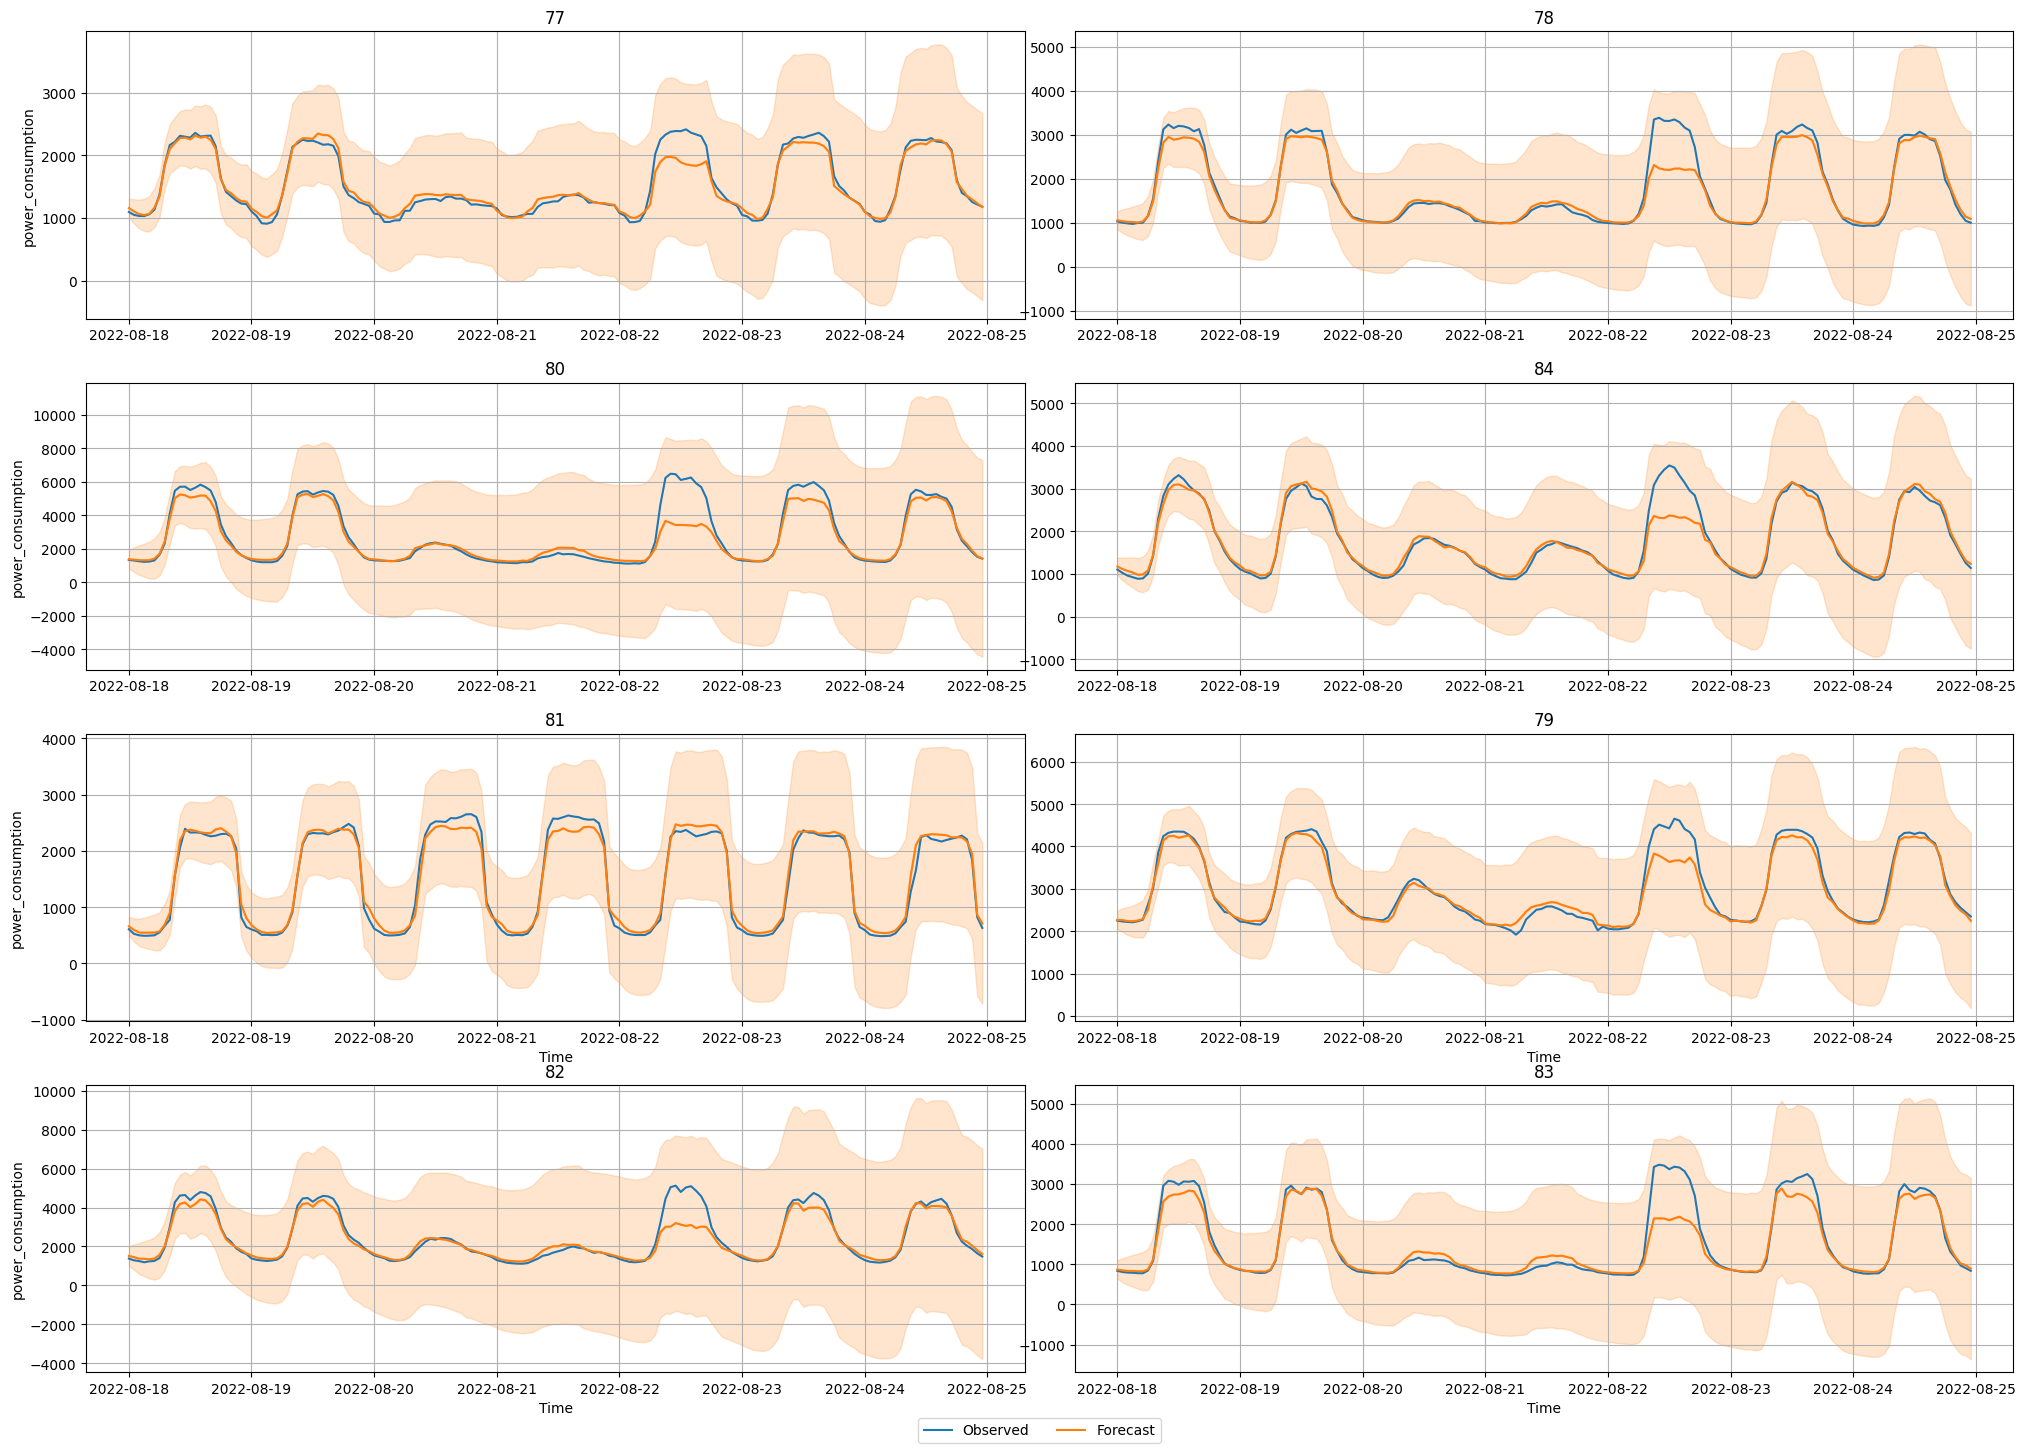

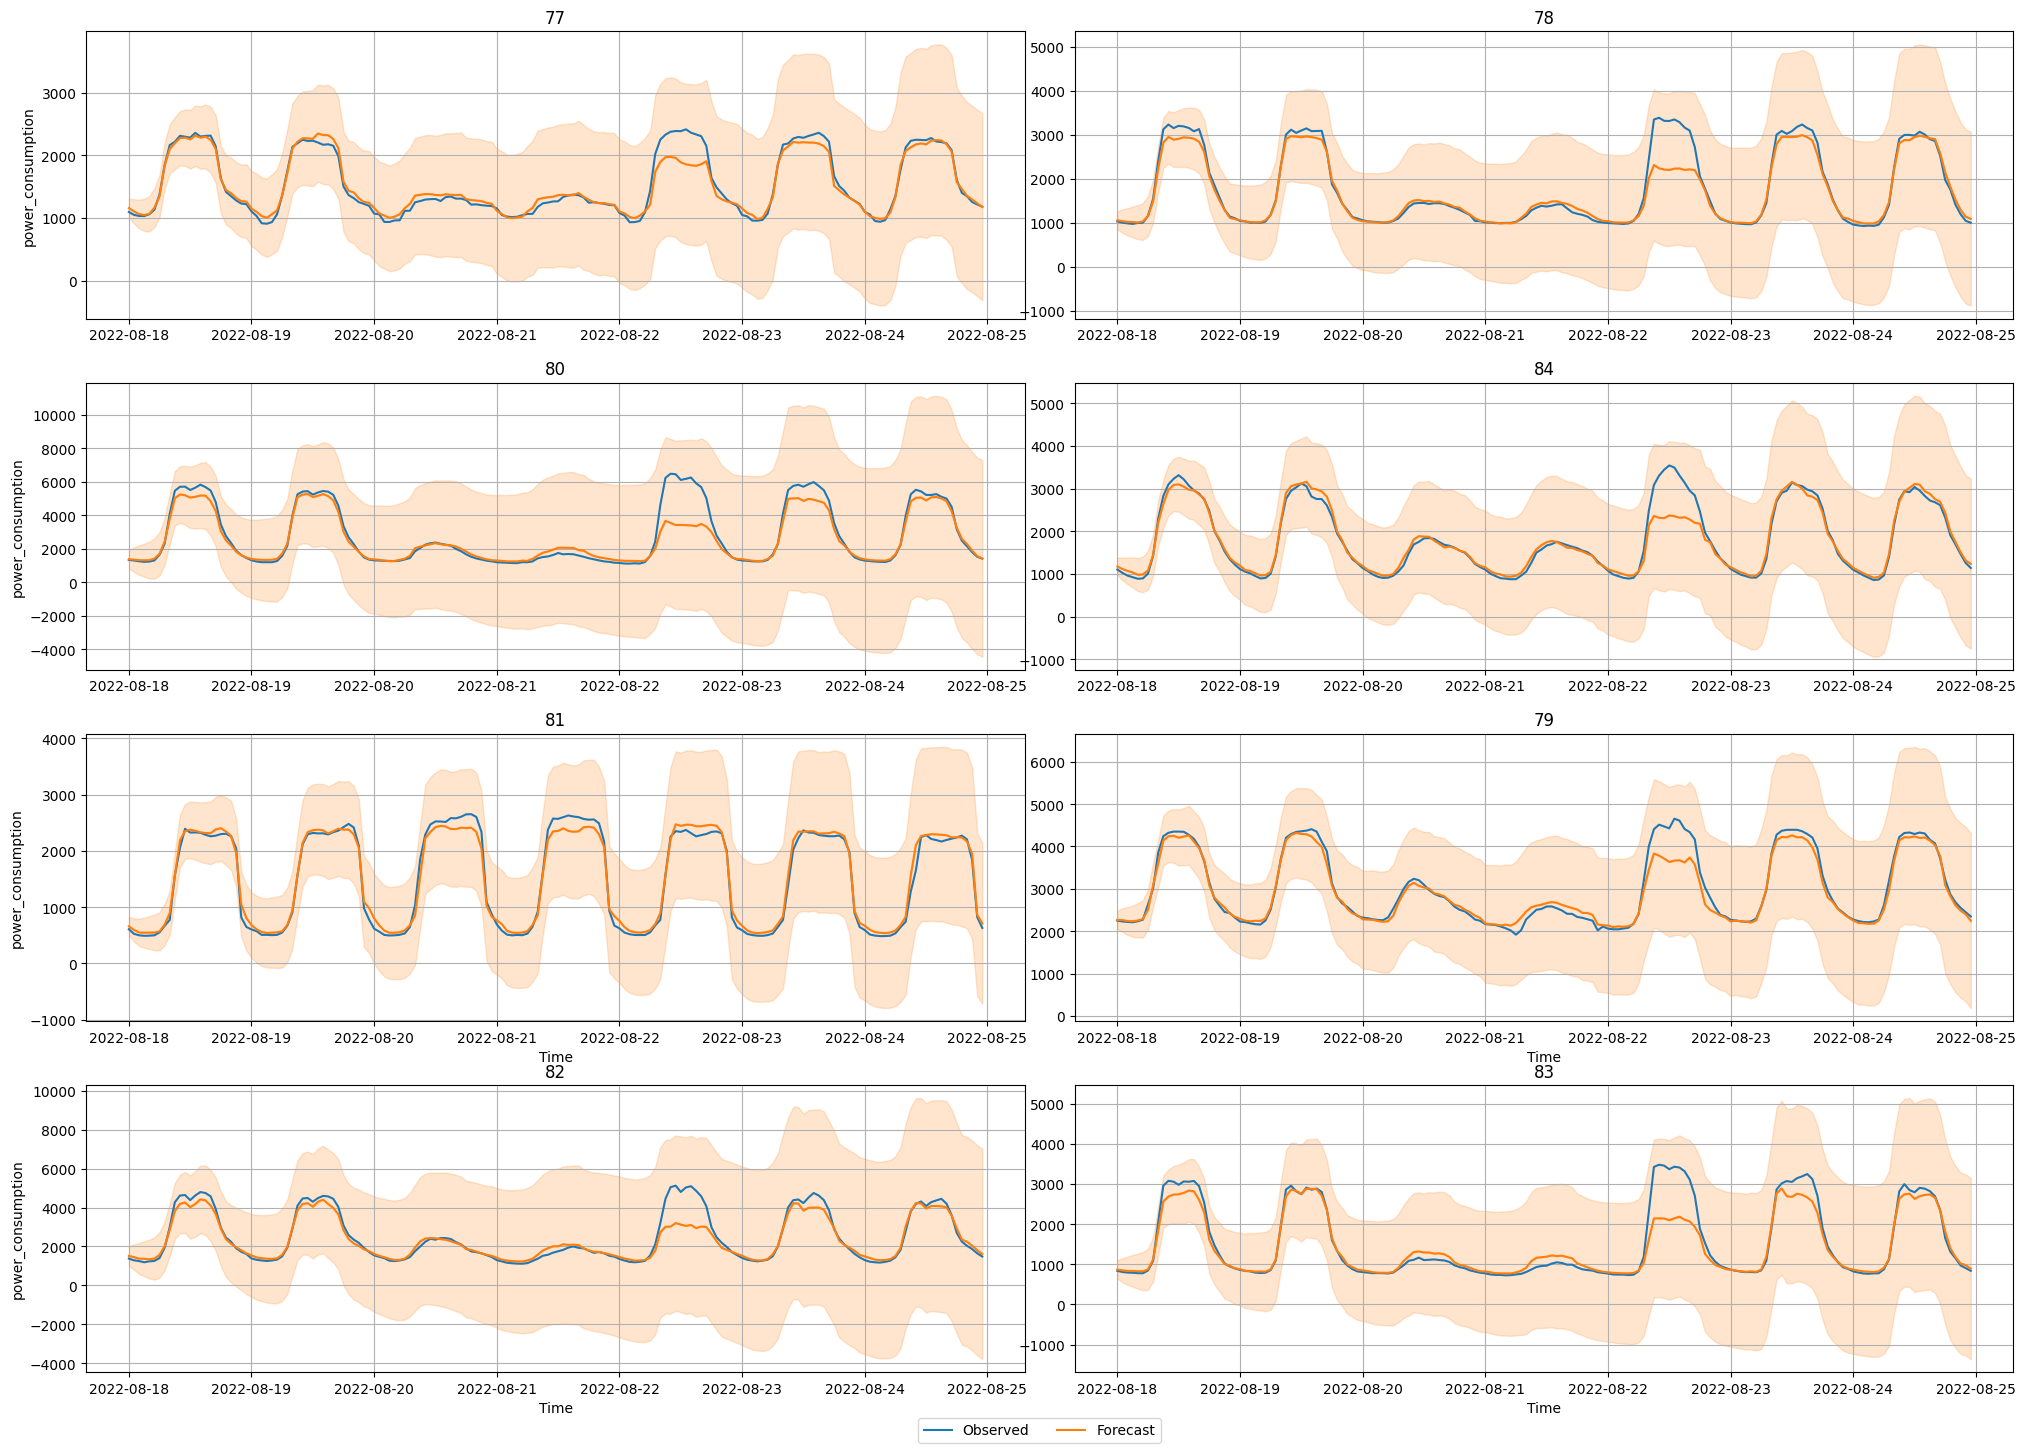

In [27]:
test_nc = TimeSeriesDataFrame(
    nc_test,
    id_column = 'building_number',
    timestamp_column = 'date_time',
    )

predictor.plot(test_nc, predictions, quantile_levels=[0.1, 0.9], max_num_item_ids = 8)

In [28]:
actuals = test_nc.reset_index()[['item_id', 'timestamp', 'power_consumption']]
predicted = predictions.reset_index()[['item_id', 'timestamp', 'mean']]
merged_df = pd.merge(test_nc, predicted, on=['item_id', 'timestamp'])

merged_df['squared_error'] = (merged_df['power_consumption'] - merged_df['mean']) ** 2
mspe_value = np.mean(merged_df['squared_error'])

print(f"MSPE: {mspe_value}")

# merged_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_nc.csv', index=False)

MSPE: 119787.68983966345


MSPE: 123324.3659812661

# Model 3 - Knowledge data with covariates

static: ['total_area', 'cooling_area']

time-varying: ['date of week', 'temperature', 'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation']

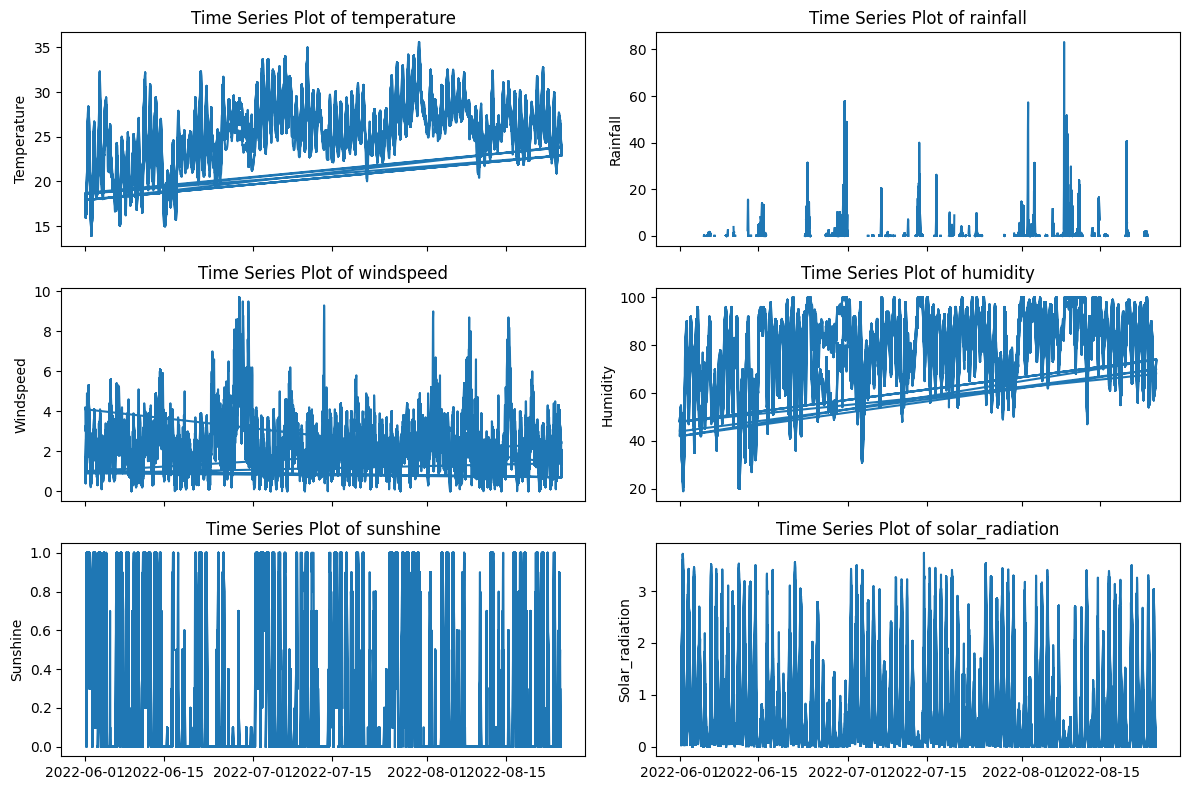

In [30]:
columns = ['temperature', 'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].plot(datak['date_time'], datak[col])
    axes[i].set_title(f'Time Series Plot of {col}')
    axes[i].set_ylabel(col.capitalize())

plt.tight_layout()
plt.show()

In [31]:
kr_holidays = holidays.KR(years=2022)

start_date = date(2022, 6, 1)
end_date = date(2022, 8, 24)

for holiday_date, name in sorted(kr_holidays.items()):
    if start_date <= holiday_date <= end_date:
        print(holiday_date, name)

2022-06-01 Local Election Day
2022-06-06 Memorial Day
2022-08-15 Liberation Day


In [32]:
wc_train = datak[datak['date_time'] <= '2022-08-17 23:00:00']
wc_test = datak[datak['date_time'] >= '2022-08-18 00:00:00']

wc_train.tail(2)

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area
16150,84,2022-08-17 22:00:00,23.3,NaN,1.5,86.0,NaN,NaN,1317.6,Knowledge Industry Center,174408.2,109973.1
16151,84,2022-08-17 23:00:00,23.3,NaN,0.8,86.0,NaN,NaN,1209.6,Knowledge Industry Center,174408.2,109973.1


In [33]:
wc_test.head(2)

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area
1872,77,2022-08-18 00:00:00,23.3,NaN,0.5,89.0,NaN,NaN,1097.64,Knowledge Industry Center,67377.14,1.0
1873,77,2022-08-18 01:00:00,23.4,NaN,1.0,89.0,NaN,NaN,1051.56,Knowledge Industry Center,67377.14,1.0


In [34]:
print("지식산업센터", datak.shape)
print("Train 데이터", wc_train.shape)
print("Test 데이터", wc_test.shape)

지식산업센터 (16320, 12)
Train 데이터 (14976, 12)
Test 데이터 (1344, 12)


In [35]:
static_features_df1 = building_info[['building_number', 'total_area', 'cooling_area']]
static_features_df1.head()

,building_number,total_area,cooling_area
0,1,110634.00,39570.00
1,2,122233.47,99000.00
2,3,171243.00,113950.00
3,4,74312.98,34419.62
4,5,205884.00,150000.00


In [36]:
train_wc= TimeSeriesDataFrame.from_data_frame(
    wc_train,
    id_column = "building_number",
    timestamp_column = "date_time",
    static_features_df = static_features_df1,
)
train_wc.head()

/usr/local/lib/python3.10/dist-packages/autogluon/timeseries/dataset/ts_dataframe.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_features.rename(columns={id_column: ITEMID}, inplace=True)


temperature  rainfall  windspeed  humidity  \
item_id timestamp                                                         
77      2022-06-01 00:00:00         17.9       NaN        1.0      48.0   
        2022-06-01 01:00:00         17.7       NaN        1.2      50.0   
        2022-06-01 02:00:00         17.5       NaN        1.7      49.0   
        2022-06-01 03:00:00         15.9       NaN        0.4      54.0   
        2022-06-01 04:00:00         16.6       NaN        2.6      53.0   

                             sunshine  solar_radiation  power_consumption  \
item_id timestamp                                                           
77      2022-06-01 00:00:00       NaN              NaN             954.00   
        2022-06-01 01:00:00       NaN              NaN             934.56   
        2022-06-01 02:00:00       NaN              NaN             873.72   
        2022-06-01 03:00:00       NaN              NaN             865.80   
        2022-06-01 04:00:00       NaN              NaN             887.40   

                                         building_type  total_area  \
item_id timestamp                                                    
77      2022-06-01 00:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 01:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 02:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 03:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 04:00:00  Knowledge Industry Center    67377.14   

                             cooling_area  
item_id timestamp                          
77      2022-06-01 00:00:00           1.0  
        2022-06-01 01:00:00           1.0  
        2022-06-01 02:00:00           1.0  
        2022-06-01 03:00:00           1.0  
        2022-06-01 04:00:00           1.0

In [37]:
train_wc.static_features.head()

,total_area,cooling_area
item_id,,
77,67377.14,1.00
78,136921.00,71771.00
79,212995.84,103115.37
80,256370.24,239.00
81,115358.28,65020.94


In [38]:
WEEKEND_INDICES = [5, 6]
timestamps = train_wc.index.get_level_values("timestamp")
train_wc["weekend"] = timestamps.weekday.isin(WEEKEND_INDICES).astype(float)

In [39]:
train_wc.head(2)

temperature  rainfall  windspeed  humidity  \
item_id timestamp                                                         
77      2022-06-01 00:00:00         17.9       NaN        1.0      48.0   
        2022-06-01 01:00:00         17.7       NaN        1.2      50.0   

                             sunshine  solar_radiation  power_consumption  \
item_id timestamp                                                           
77      2022-06-01 00:00:00       NaN              NaN             954.00   
        2022-06-01 01:00:00       NaN              NaN             934.56   

                                         building_type  total_area  \
item_id timestamp                                                    
77      2022-06-01 00:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 01:00:00  Knowledge Industry Center    67377.14   

                             cooling_area  weekend  
item_id timestamp                                   
77      2022-06-01 00:00:00           1.0      0.0  
        2022-06-01 01:00:00           1.0      0.0

In [40]:
def add_holiday_features(
    ts_df: TimeSeriesDataFrame,
    country_holidays: dict,
    include_individual_holidays: bool = True,
    include_holiday_indicator: bool = True,
) -> TimeSeriesDataFrame:
    """Add holiday indicator columns to a TimeSeriesDataFrame."""
    ts_df = ts_df.copy()
    timestamps = ts_df.index.get_level_values("timestamp")
    country_holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    holidays_df = country_holidays_df.reindex(timestamps.date).fillna(0)
    if include_individual_holidays:
        ts_df[holidays_df.columns] = holidays_df.values
    if include_holiday_indicator:
        ts_df["Holiday"] = holidays_df.max(axis=1).values
    return ts_df

In [41]:
train_wc_with_holidays = add_holiday_features(train_wc, kr_holidays)
train_wc_with_holidays.head(1)

,,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area,...,Local Election Day,Memorial Day,National Foundation Day,New Year's Day,Presidential Election Day,The day preceding Chuseok,The day preceding Korean New Year,The second day of Chuseok,The second day of Korean New Year,Holiday
item_id,timestamp,,,,,,,,,,,,,,,,,,,,,
77,2022-06-01,17.9,NaN,1.0,48.0,NaN,NaN,954.0,Knowledge Industry Center,67377.14,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
holiday_columns = train_wc_with_holidays.columns.difference(train_wc.columns)

In [43]:
static_features_df1 = building_info[['building_number', 'total_area', 'cooling_area']]
static_features_df1.shape

(100, 3)

In [44]:
test_wc = TimeSeriesDataFrame.from_data_frame(
    wc_test,
    id_column = "building_number",
    timestamp_column = "date_time",
    static_features_df = static_features_df1,
)
test_wc.head()

/usr/local/lib/python3.10/dist-packages/autogluon/timeseries/dataset/ts_dataframe.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_features.rename(columns={id_column: ITEMID}, inplace=True)


temperature  rainfall  windspeed  humidity  \
item_id timestamp                                                         
77      2022-08-18 00:00:00         23.3       NaN        0.5      89.0   
        2022-08-18 01:00:00         23.4       NaN        1.0      89.0   
        2022-08-18 02:00:00         23.3       NaN        1.0      90.0   
        2022-08-18 03:00:00         21.9       NaN        1.3      96.0   
        2022-08-18 04:00:00         22.2       NaN        1.0      96.0   

                             sunshine  solar_radiation  power_consumption  \
item_id timestamp                                                           
77      2022-08-18 00:00:00       NaN              NaN            1097.64   
        2022-08-18 01:00:00       NaN              NaN            1051.56   
        2022-08-18 02:00:00       NaN              NaN            1033.92   
        2022-08-18 03:00:00       NaN              NaN            1032.48   
        2022-08-18 04:00:00       NaN              NaN            1062.72   

                                         building_type  total_area  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 01:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 02:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 03:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 04:00:00  Knowledge Industry Center    67377.14   

                             cooling_area  
item_id timestamp                          
77      2022-08-18 00:00:00           1.0  
        2022-08-18 01:00:00           1.0  
        2022-08-18 02:00:00           1.0  
        2022-08-18 03:00:00           1.0  
        2022-08-18 04:00:00           1.0

In [45]:
test_wc_with_holidays = add_holiday_features(test_wc, kr_holidays)

In [47]:
train_wc_with_holidays.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 14976 entries, (77, Timestamp('2022-06-01 00:00:00')) to (84, Timestamp('2022-08-17 23:00:00'))
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   temperature                         14976 non-null  float64
 1   rainfall                            3214 non-null   float64
 2   windspeed                           14976 non-null  float64
 3   humidity                            14976 non-null  float64
 4   sunshine                            9321 non-null   float64
 5   solar_radiation                     9321 non-null   float64
 6   power_consumption                   14976 non-null  float64
 7   building_type                       14976 non-null  object 
 8   total_area                          14976 non-null  float64
 9   cooling_area                        14976 non-null  float64
 10  we

In [48]:
holiday_columns = train_wc_with_holidays.columns.difference(train_wc.columns)

cleaned_holiday_columns = [col.replace('weekend', '') for col in holiday_columns]

known_covariates_names = cleaned_holiday_columns + ['weekend']


predictor = TimeSeriesPredictor(
    prediction_length = 168,
    path = "autogluon-energy-knowledge-3600-high-holidays",
    target = "power_consumption",
    eval_metric = "MSE",
    known_covariates_names = known_covariates_names
)

predictor.fit(
    train_wc_with_holidays,
    presets = "high_quality",
    time_limit = 3600
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'autogluon-energy-knowledge-3600-high-holidays'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Fri May 24 14:06:39 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.59 GB / 12.67 GB (75.6%)
Disk Space Avail:   76.17 GB / 107.72 GB (70.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': ['Alternative holiday for Chuseok',
                            'Alternative holiday for Hangul Day',
                            "Buddha's Birthday",
                            "Children's Day",
                            'Christmas Day',
                            'Chuseok',
                            'Hangul Day',
              

In [53]:
known_covariates_names

['Alternative holiday for Chuseok',
 'Alternative holiday for Hangul Day',
 "Buddha's Birthday",
 "Children's Day",
 'Christmas Day',
 'Chuseok',
 'Hangul Day',
 'Holiday',
 'Independence Movement Day',
 'Korean New Year',
 'Liberation Day',
 'Local Election Day',
 'Memorial Day',
 'National Foundation Day',
 "New Year's Day",
 'Presidential Election Day',
 'The day preceding Chuseok',
 'The day preceding Korean New Year',
 'The second day of Chuseok',
 'The second day of Korean New Year',
 'weekend']

In [56]:
future_index = get_forecast_horizon_index_ts_dataframe(train_wc_with_holidays, prediction_length=168)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)
known_covariates["weekend"] = future_timestamps.weekday.isin(WEEKEND_INDICES).astype(float)
known_covariates = add_holiday_features(known_covariates, kr_holidays)

known_covariates.head()

weekend  Alternative holiday for Chuseok  \
item_id timestamp                                                       
77      2022-08-18 00:00:00      0.0                              0.0   
        2022-08-18 01:00:00      0.0                              0.0   
        2022-08-18 02:00:00      0.0                              0.0   
        2022-08-18 03:00:00      0.0                              0.0   
        2022-08-18 04:00:00      0.0                              0.0   

                             Alternative holiday for Hangul Day  \
item_id timestamp                                                 
77      2022-08-18 00:00:00                                 0.0   
        2022-08-18 01:00:00                                 0.0   
        2022-08-18 02:00:00                                 0.0   
        2022-08-18 03:00:00                                 0.0   
        2022-08-18 04:00:00                                 0.0   

                             Buddha's Birthday  Children's Day  Christmas Day  \
item_id timestamp                                                               
77      2022-08-18 00:00:00                0.0             0.0            0.0   
        2022-08-18 01:00:00                0.0             0.0            0.0   
        2022-08-18 02:00:00                0.0             0.0            0.0   
        2022-08-18 03:00:00                0.0             0.0            0.0   
        2022-08-18 04:00:00                0.0             0.0            0.0   

                             Chuseok  Hangul Day  Independence Movement Day  \
item_id timestamp                                                             
77      2022-08-18 00:00:00      0.0         0.0                        0.0   
        2022-08-18 01:00:00      0.0         0.0                        0.0   
        2022-08-18 02:00:00      0.0         0.0                        0.0   
        2022-08-18 03:00:00      0.0         0.0                        0.0   
        2022-08-18 04:00:00      0.0         0.0                        0.0   

                             Korean New Year  ...  Local Election Day  \
item_id timestamp                             ...                       
77      2022-08-18 00:00:00              0.0  ...                 0.0   
        2022-08-18 01:00:00              0.0  ...                 0.0   
        2022-08-18 02:00:00              0.0  ...                 0.0   
        2022-08-18 03:00:00              0.0  ...                 0.0   
        2022-08-18 04:00:00              0.0  ...                 0.0   

                             Memorial Day  National Foundation Day  \
item_id timestamp                                                    
77      2022-08-18 00:00:00           0.0                      0.0   
        2022-08-18 01:00:00           0.0                      0.0   
        2022-08-18 02:00:00           0.0                      0.0   
        2022-08-18 03:00:00           0.0                      0.0   
        2022-08-18 04:00:00           0.0                      0.0   

                             New Year's Day  Presidential Election Day  \
item_id timestamp                                                        
77      2022-08-18 00:00:00             0.0                        0.0   
        2022-08-18 01:00:00             0.0                        0.0   
        2022-08-18 02:00:00             0.0                        0.0   
        2022-08-18 03:00:00             0.0                        0.0   
        2022-08-18 04:00:00             0.0                        0.0   

                             The day preceding Chuseok  \
item_id timestamp                                        
77      2022-08-18 00:00:00                        0.0   
        2022-08-18 01:00:00                        0.0   
        2022-08-18 02:00:00                        0.0   
        2022-08-18 03:00:00                        0.0   
        2022-08-18 04:00:00                        0.0 

In [57]:
predictions = predictor.predict(train_wc_with_holidays, known_covariates=known_covariates)
predictions.head(2)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1080.009554  1003.551981  1033.644396   
        2022-08-18 01:00:00  1036.912670   946.638653   976.016843   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1053.208615  1068.918862  1080.009554   
        2022-08-18 01:00:00   998.457126  1017.836302  1036.912670   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1087.918118  1098.875496  1113.669939   
        2022-08-18 01:00:00  1042.123223  1056.963977  1073.843896   

                                     0.9  
item_id timestamp                         
77      2022-08-18 00:00:00  1131.037593  
        2022-08-18 01:00:00  1102.358927

<Figure size 1200x1000 with 0 Axes>

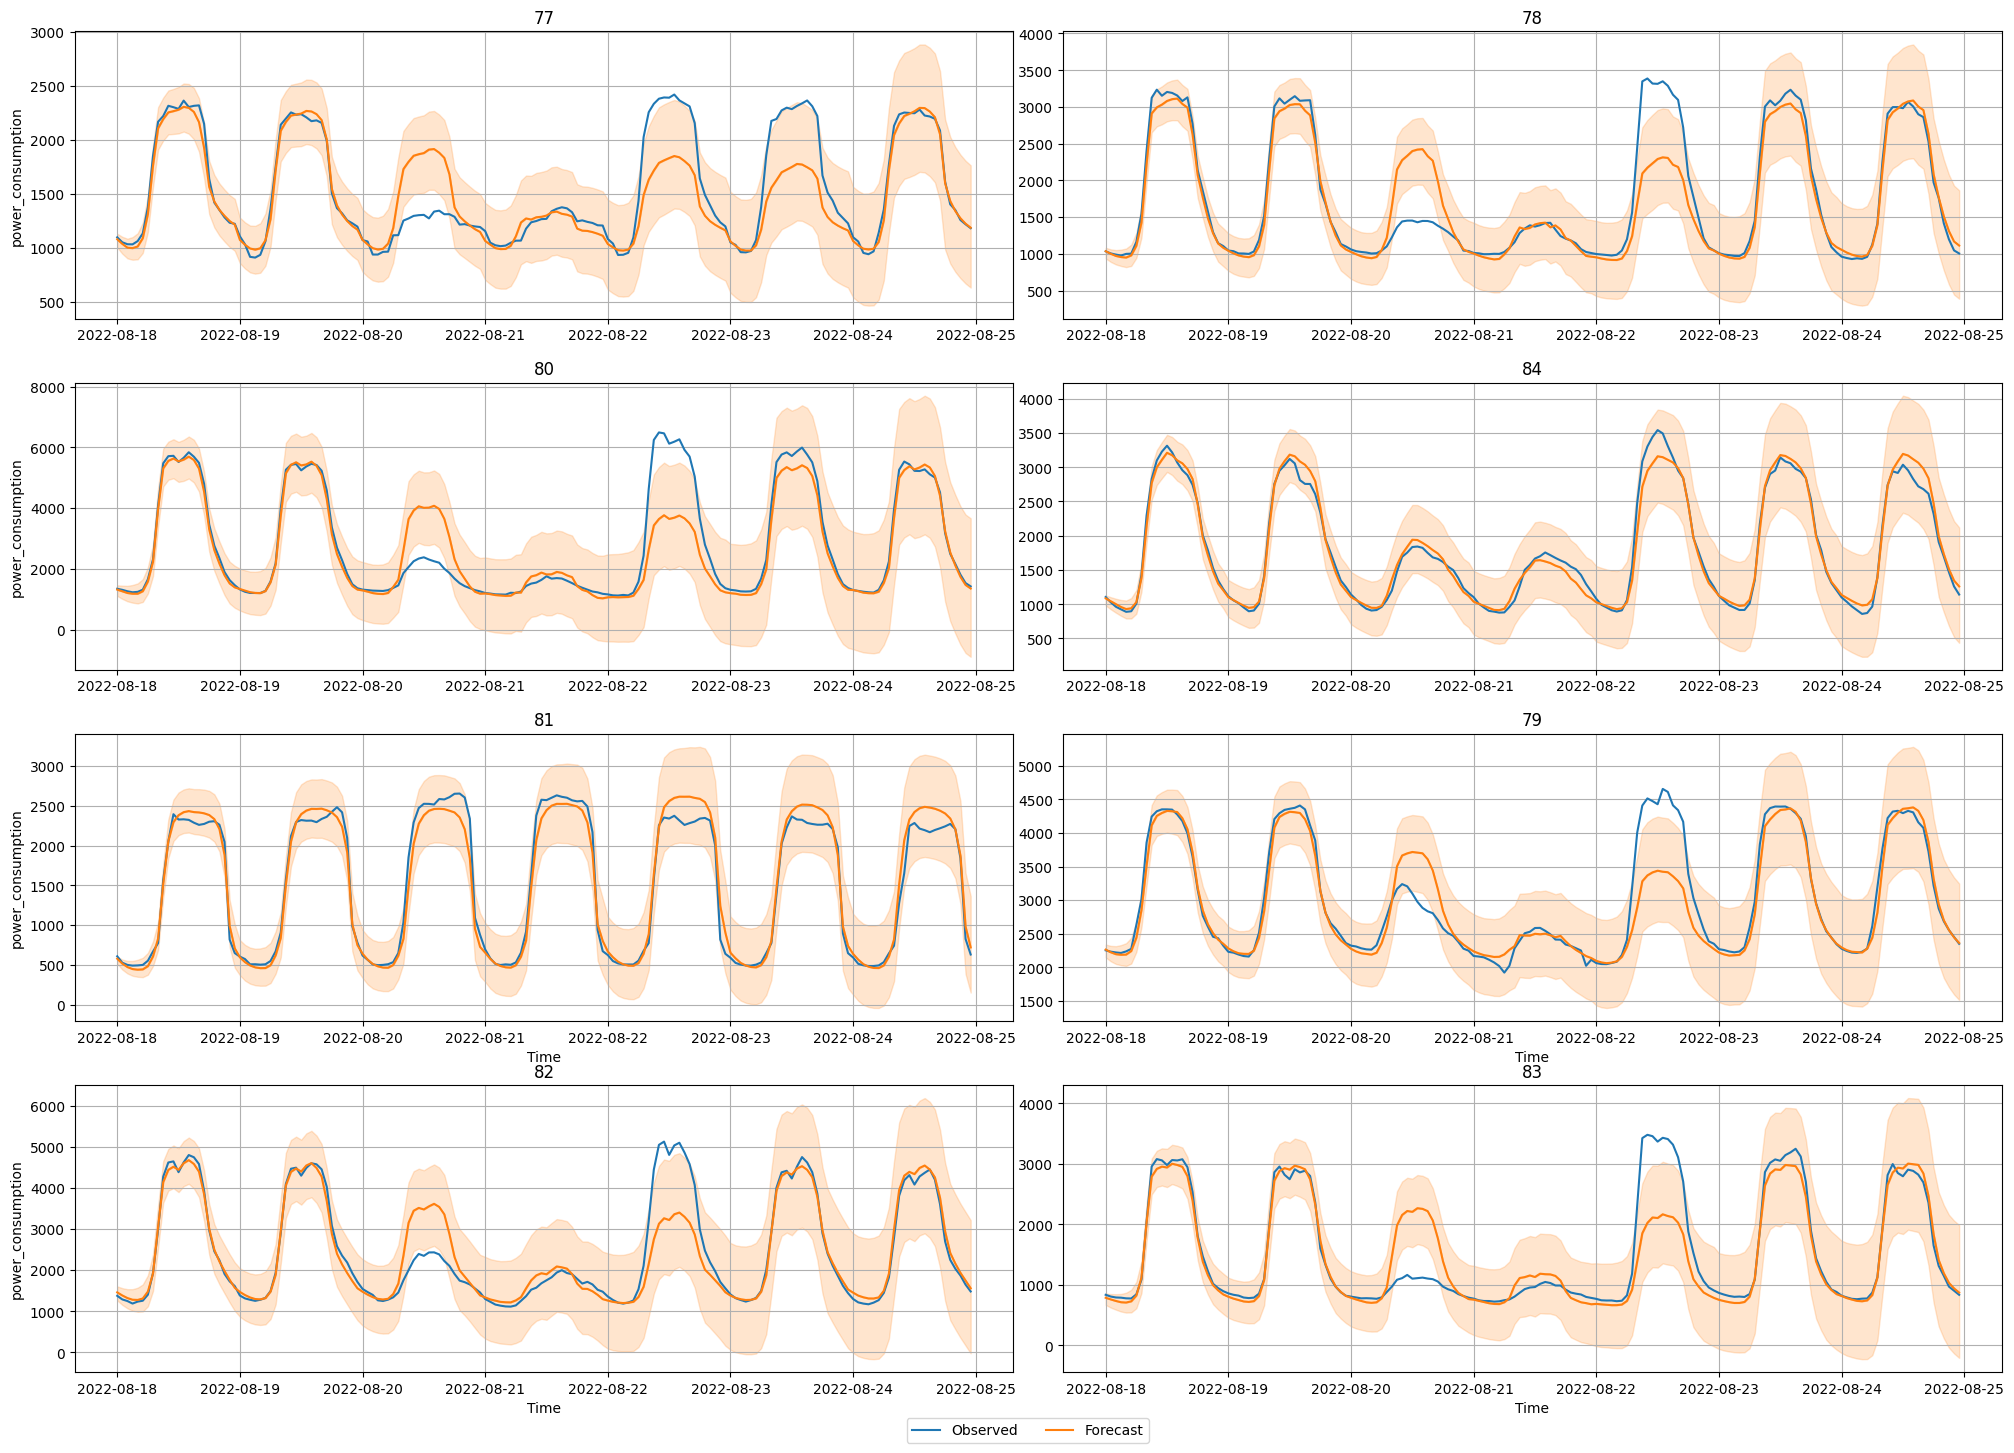

In [58]:
plt.figure(figsize=(12, 10))
predictor.plot(test_wc_with_holidays, predictions, quantile_levels=[0.1, 0.9], max_num_item_ids = 8)
plt.show()

In [59]:
actuals = test_wc_with_holidays.reset_index()[['item_id', 'timestamp', 'power_consumption']]
predicted = predictions.reset_index()[['item_id', 'timestamp', 'mean']]
merged_df = pd.merge(test_wc_with_holidays, predicted, on=['item_id', 'timestamp'])

merged_df['squared_error'] = (merged_df['power_consumption'] - merged_df['mean']) ** 2
mspe_value = np.mean(merged_df['squared_error'])

print(f"MSPE: {mspe_value}")

# merged_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_holidays.csv', index=False)

MSPE: 159170.87585427405


MSPE: 56824.39280830474